# **Here, we are creating a Neural Network model from scratch that will be able to recognize hand written digits from the MNIST dataset. Earlier, I used Mean squared error as the loss function for the model, now I am using Cross entropy as the loss function. I also added L2 weight regularisation and some intelligent weight initialization techniques to compare the results at the end.**

**Importing the necessary libraries-**

In [1]:
import pickle #in the original code, it was cPickle. Changed it to pickle as cPickle is not supported anymore in latest versions of python
import gzip
import numpy as np
import pandas as pd
from time import time
%matplotlib inline
import matplotlib.pyplot as plt
import json
import random
import sys

**Loading the MNIST data-**

In [2]:
def load_data():
    f = gzip.open('mnist.pkl.gz', 'rb')
    training_data, validation_data, test_data = pickle.load(f,encoding='iso-8859-1') #changed the encoding to iso-8859-1
    f.close()
    return (training_data, validation_data, test_data)  

In [3]:
def load_data_wrapper():
    tr_d, va_d, te_d = load_data()
    training_inputs = [np.reshape(x, (784, 1)) for x in tr_d[0]]
    training_results = [vectorized_result(y) for y in tr_d[1]]
    training_data = list(zip(training_inputs, training_results)) #In python 3.x the object returned by zip() isn't a list, so we added list
    validation_inputs = [np.reshape(x, (784, 1)) for x in va_d[0]]
    validation_data = list(zip(validation_inputs, va_d[1]))
    test_inputs = [np.reshape(x, (784, 1)) for x in te_d[0]]
    test_data = list(zip(test_inputs, te_d[1]))
    return (training_data, validation_data, test_data)

In [4]:
def vectorized_result(j): 
    e = np.zeros((10, 1))
    e[j] = 1.0
    return e

In [5]:
def TabularFormat(epochs,eval_cost,eval_acc,train_cost,train_acc):
  ep = []
  for i in range(epochs):
    ep.append(i)
  return pd.DataFrame(list(zip(ep,train_cost,train_acc,eval_cost,eval_acc)),columns = ['Epoch Value','Training Loss','Training Accuracy','Evaluation loss','Evaluation Accuracy'])

In [6]:
def GraphicalFormat(epochs,eval_cost,eval_acc,train_cost,train_acc):
  ep = []
  for i in range(epochs):
    ep.append(i)

  plt.figure(figsize =(10,6))
  plt.plot(eval_cost,label = "Evaluation Loss")
  plt.plot(train_cost,label = "Training Loss")
  plt.ylabel("Loss",fontsize = 15)
  plt.xlabel("No. of Epoch",fontsize = 15)
  plt.legend(fontsize = 12)
  plt.title("Graph between value of Loss function V/s Epochs",fontsize = 15)
  plt.show()
  print("\n\n__________________________________________________\n\n")
  plt.figure(figsize =(10,6))
  plt.plot(train_acc,label = "Training Accuracy")
  plt.plot(eval_acc,label = "Evaluation Accuracy")
  plt.ylabel("Accuracy",fontsize = 15)
  plt.xlabel("No. of Epoch",fontsize = 15)
  plt.legend(fontsize = 12)
  plt.title("Graph between Accuracies V/s Epochs",fontsize = 15)
  plt.show()

In [7]:
class QuadraticCost(object):
    def fn(a, y):
        """Returns the cost associated with an output a and desired output y """
        return 0.5*np.linalg.norm(a-y)**2

    
    def delta(z, a, y):
        """Returns the error delta from the output layer."""
        return (a-y) * sigmoid_prime(z)

In [8]:
class CrossEntropyCost(object):
    def fn(a, y):
        """Return the cost associated with an output a and desired output y. """
        return np.sum(np.nan_to_num(-y*np.log(a)))

    def delta(z, a, y):
        """Return the error delta from the output layer.  """
        return (a-y)

**Defining the Neural network-**

In [9]:
class Network(object):

    def __init__(self, sizes, cost=CrossEntropyCost):

        self.num_layers = len(sizes)
        self.sizes = sizes
        self.default_weight_initializer()
        self.cost=cost

    def default_weight_initializer(self):
      
        self.biases = [np.random.randn(y, 1) for y in self.sizes[1:]]
        self.weights = [np.random.randn(y, x)/np.sqrt(x) for x, y in zip(self.sizes[:-1], self.sizes[1:])]

    def large_weight_initializer(self):
       
        self.biases = [np.random.randn(y, 1) for y in self.sizes[1:]]
        self.weights = [np.random.randn(y, x) for x, y in zip(self.sizes[:-1], self.sizes[1:])]

    def feedforward(self, a):
        """Return the output of the network if ``a`` is input."""
        for b, w in zip(self.biases, self.weights):
            a = sigmoid(np.dot(w, a)+b)
        return a

    def SGD(self, training_data, epochs, mini_batch_size, eta,
            lmbda = 0.0,
            evaluation_data=None,
            monitor_evaluation_cost=False,
            monitor_evaluation_accuracy=False,
            monitor_training_cost=False,
            monitor_training_accuracy=False):
     
        if evaluation_data: n_data = len(evaluation_data)
        n = len(training_data)
        evaluation_cost, evaluation_accuracy = [], []
        training_cost, training_accuracy = [], []
        for j in range(epochs):
            random.shuffle(training_data)
            mini_batches = [
                training_data[k:k+mini_batch_size]
                for k in range(0, n, mini_batch_size)]
            for mini_batch in mini_batches:
                self.update_mini_batch(
                    mini_batch, eta, lmbda, len(training_data))
            print("Epoch %s training complete\n" %j)
            if monitor_training_cost:
                cost = self.total_cost(training_data, lmbda)
                training_cost.append(cost)
                #print ("Cost on training data: {}".format(cost))


            if monitor_training_accuracy:
                accuracy = self.accuracy(training_data, convert=True)
                training_accuracy.append((accuracy/len(training_data))*100)
                #print ("Accuracy on training data: {} / {}".format(accuracy, n))
                #print("\n")


            if monitor_evaluation_cost:
                cost = self.total_cost(evaluation_data, lmbda, convert=True)
                evaluation_cost.append(cost)
                #print ("Cost on evaluation data: {}".format(cost))


            if monitor_evaluation_accuracy:
                accuracy = self.accuracy(evaluation_data)
                evaluation_accuracy.append(accuracy/len(evaluation_data)*100)
                print ("Accuracy on evaluation data: {} / {}".format(self.accuracy(evaluation_data), n_data))
                print("_________________________________________________________________\n")

        return evaluation_cost, evaluation_accuracy, \
            training_cost, training_accuracy


    def update_mini_batch(self, mini_batch, eta, lmbda, n):
        """Update the network's weights and biases by applying gradient
        descent using backpropagation to a single mini batch.  The
        ``mini_batch`` is a list of tuples ``(x, y)``, ``eta`` is the
        learning rate, ``lmbda`` is the regularization parameter, and
        ``n`` is the total size of the training data set.
        """
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        for x, y in mini_batch:
            delta_nabla_b, delta_nabla_w = self.backprop(x, y)
            nabla_b = [nb+dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
            nabla_w = [nw+dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
        self.weights = [(1-eta*(lmbda/n))*w-(eta/len(mini_batch))*nw for w, nw in zip(self.weights, nabla_w)]
        self.biases = [b-(eta/len(mini_batch))*nb for b, nb in zip(self.biases, nabla_b)]

    def backprop(self, x, y):
        """Return a tuple ``(nabla_b, nabla_w)`` representing the
        gradient for the cost function C_x.  ``nabla_b`` and
        ``nabla_w`` are layer-by-layer lists of numpy arrays, similar
        to ``self.biases`` and ``self.weights``."""
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        # feedforward
        activation = x
        activations = [x] # list to store all the activations, layer by layer
        zs = [] # list to store all the z vectors, layer by layer
        for b, w in zip(self.biases, self.weights):
            z = np.dot(w, activation)+b
            zs.append(z)
            activation = sigmoid(z)
            activations.append(activation)

        """ Adding the softmax activation at last layer"""
        Numerator = np.exp(zs[-1])
        Denominator = sum(Numerator)
        activations[-1] = Numerator / Denominator


        # backward pass
        delta = (self.cost).delta(zs[-1], activations[-1], y)
        nabla_b[-1] = delta
        nabla_w[-1] = np.dot(delta, activations[-2].transpose())
        # Note that the variable l in the loop below is used a little
        # differently to the notation in Chapter 2 of the book.  Here,
        # l = 1 means the last layer of neurons, l = 2 is the
        # second-last layer, and so on.  It's a renumbering of the
        # scheme in the book, used here to take advantage of the fact
        # that Python can use negative indices in lists.
        for l in range(2, self.num_layers):
            z = zs[-l]
            sp = sigmoid_prime(z)
            delta = np.dot(self.weights[-l+1].transpose(), delta) * sp
            nabla_b[-l] = delta
            nabla_w[-l] = np.dot(delta, activations[-l-1].transpose())
        return (nabla_b, nabla_w)

    def accuracy(self, data, convert=False):
   
        
        if convert:
            results = [(np.argmax(self.feedforward(x)), np.argmax(y))
                       for (x, y) in data]
        else:
            results = [(np.argmax(self.feedforward(x)), y)
                        for (x, y) in data]
        return sum(int(x == y) for (x, y) in results)

    def total_cost(self, data, lmbda, convert=False):
        
        cost = 0.0
        for x, y in data:
            a = self.feedforward(x)
            if convert: y = vectorized_result(y)
            cost += self.cost.fn(a, y)/len(data)
        cost += 0.5*(lmbda/len(data))*sum(
            np.linalg.norm(w)**2 for w in self.weights)
        return cost
		
#### Miscellaneous functions
def sigmoid(z):
    """The sigmoid function."""
    return 1.0/(1.0+np.exp(-z))

def sigmoid_prime(z):
    """Derivative of the sigmoid function."""
    return sigmoid(z)*(1-sigmoid(z))


In [10]:
training_data, validation_data, test_data = load_data_wrapper()

1. **Training our Neural Network with 28 neurons in hidden layer, 100 epochs, mini_batch size of 10 and learning rate of 0.01**

In [11]:
net = Network([784, 28, 10], cost = CrossEntropyCost)
epochs = 100
mini_batch_size = 10
eta = 0.01
lmbda = 0
evaluation_data = test_data
monitor_evaluation_cost = True
monitor_evaluation_accuracy = True
monitor_training_cost = True
monitor_training_accuracy = True
net.large_weight_initializer()
eval_cost,eval_acc,train_cost,train_acc = net.SGD(training_data, epochs, mini_batch_size, eta, lmbda,evaluation_data,monitor_evaluation_cost, monitor_evaluation_accuracy,monitor_training_cost, monitor_training_accuracy)

Epoch 0 training complete

Accuracy on evaluation data: 6056 / 10000
_________________________________________________________________

Epoch 1 training complete

Accuracy on evaluation data: 7212 / 10000
_________________________________________________________________

Epoch 2 training complete

Accuracy on evaluation data: 7686 / 10000
_________________________________________________________________

Epoch 3 training complete

Accuracy on evaluation data: 7960 / 10000
_________________________________________________________________

Epoch 4 training complete

Accuracy on evaluation data: 8157 / 10000
_________________________________________________________________

Epoch 5 training complete

Accuracy on evaluation data: 8259 / 10000
_________________________________________________________________

Epoch 6 training complete

Accuracy on evaluation data: 8387 / 10000
_________________________________________________________________

Epoch 7 training complete

Accuracy on evaluatio

In [12]:
df = TabularFormat(epochs,eval_cost,eval_acc,train_cost,train_acc)
df

,Epoch Value,Training Loss,Training Accuracy,Evaluation loss,Evaluation Accuracy
0,0,0.111188,58.680,0.102562,60.56
1,1,0.073231,70.240,0.065388,72.12
2,2,0.055076,75.442,0.048719,76.86
3,3,0.045750,78.504,0.040294,79.60
4,4,0.039029,80.490,0.034454,81.57
...,...,...,...,...,...
95,95,0.007937,94.058,0.010493,93.14
96,96,0.007924,94.050,0.010612,93.15
97,97,0.007859,94.094,0.010453,93.17
98,98,0.007814,94.122,0.010462,93.24


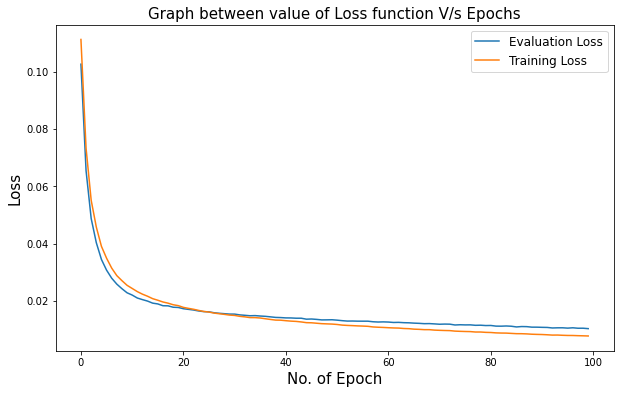



__________________________________________________




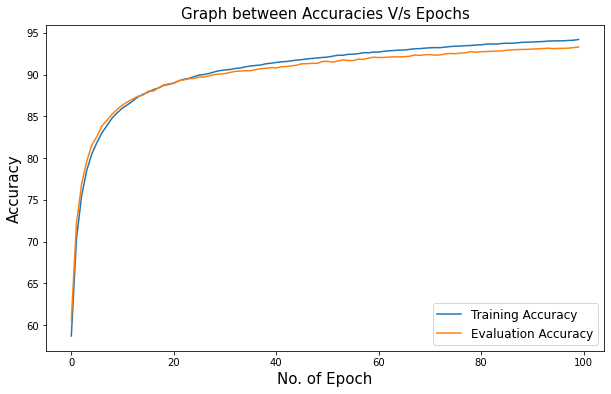

In [13]:
GraphicalFormat(epochs,eval_cost,eval_acc,train_cost,train_acc)

**Observation-** We see that we are getting decent accuracy at eta value of 0.01 is still increasing, so we increase the learning rate.

In [14]:
net = Network([784, 28, 10], cost=CrossEntropyCost)
epochs = 100
mini_batch_size = 10
eta = 0.1
lmbda = 0
evaluation_data = test_data
monitor_evaluation_cost = True
monitor_evaluation_accuracy = True
monitor_training_cost = True
monitor_training_accuracy = True
net.large_weight_initializer()
eval_cost,eval_acc,train_cost,train_acc = net.SGD(training_data, epochs, mini_batch_size, eta, lmbda,evaluation_data,monitor_evaluation_cost, monitor_evaluation_accuracy,monitor_training_cost, monitor_training_accuracy)

Epoch 0 training complete

Accuracy on evaluation data: 8564 / 10000
_________________________________________________________________

Epoch 1 training complete

Accuracy on evaluation data: 8856 / 10000
_________________________________________________________________

Epoch 2 training complete

Accuracy on evaluation data: 8954 / 10000
_________________________________________________________________

Epoch 3 training complete

Accuracy on evaluation data: 9064 / 10000
_________________________________________________________________

Epoch 4 training complete

Accuracy on evaluation data: 9132 / 10000
_________________________________________________________________

Epoch 5 training complete

Accuracy on evaluation data: 9175 / 10000
_________________________________________________________________

Epoch 6 training complete

Accuracy on evaluation data: 9201 / 10000
_________________________________________________________________

Epoch 7 training complete

Accuracy on evaluatio

In [15]:
df = TabularFormat(epochs,eval_cost,eval_acc,train_cost,train_acc)
df

,Epoch Value,Training Loss,Training Accuracy,Evaluation loss,Evaluation Accuracy
0,0,0.081763,85.022,0.077864,85.64
1,1,0.054970,88.380,0.053873,88.56
2,2,0.042852,89.800,0.044084,89.54
3,3,0.035561,90.826,0.038047,90.64
4,4,0.030027,91.628,0.033911,91.32
...,...,...,...,...,...
95,95,0.001682,98.550,0.012595,94.20
96,96,0.001650,98.656,0.012153,94.02
97,97,0.001596,98.620,0.012335,93.91
98,98,0.001502,98.652,0.011811,94.04


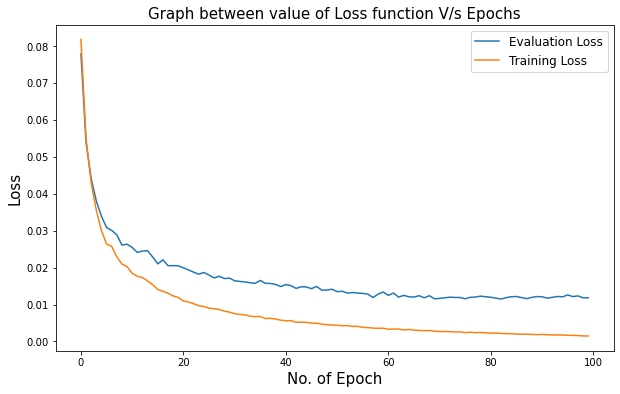



__________________________________________________




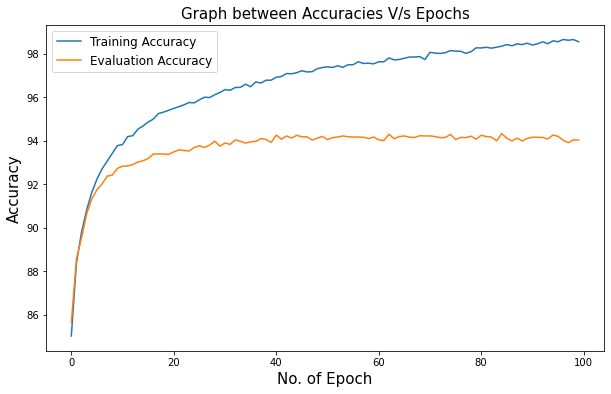

In [16]:
GraphicalFormat(epochs,eval_cost,eval_acc,train_cost,train_acc)

# **Computing for different values of Eta-**

In [20]:
monitor_evaluation_cost = True
monitor_evaluation_accuracy = True
monitor_training_cost = True
monitor_training_accuracy = True

In [21]:
net = Network([784, 28, 10], cost=CrossEntropyCost)
epochs = 100
mini_batch_size = 10
eta = [0.03,0.05,0.08]
lmbda = 0
evaluation_data = validation_data
dash = "_____________________________________________________________"
eval_cost_list_1 = []
eval_acc_list_1 = []
train_cost_list_1 = []
train_acc_list_1 = []
for i in range(len(eta)):
  net.large_weight_initializer()
  print("Calculations for the eta value =",eta[i],"\n")
  eval_cost,eval_acc,train_cost,train_acc = net.SGD(training_data, epochs, mini_batch_size, eta[i], lmbda,evaluation_data,monitor_evaluation_cost, monitor_evaluation_accuracy,monitor_training_cost, monitor_training_accuracy)
  eval_cost_list_1.append(eval_cost)
  eval_acc_list_1.append(eval_acc)
  train_cost_list_1.append(train_cost)
  train_acc_list_1.append(train_acc)
  print(dash)

Calculations for the eta value = 0.03 

Epoch 0 training complete

Accuracy on evaluation data: 7944 / 10000
_________________________________________________________________

Epoch 1 training complete

Accuracy on evaluation data: 8425 / 10000
_________________________________________________________________

Epoch 2 training complete

Accuracy on evaluation data: 8636 / 10000
_________________________________________________________________

Epoch 3 training complete

Accuracy on evaluation data: 8771 / 10000
_________________________________________________________________

Epoch 4 training complete

Accuracy on evaluation data: 8866 / 10000
_________________________________________________________________

Epoch 5 training complete

Accuracy on evaluation data: 8941 / 10000
_________________________________________________________________

Epoch 6 training complete

Accuracy on evaluation data: 8998 / 10000
_________________________________________________________________

Epoch 7 

**Graph between values of Validation Accuracy And Training Accuracy V/s Epochs for different values of Eta**

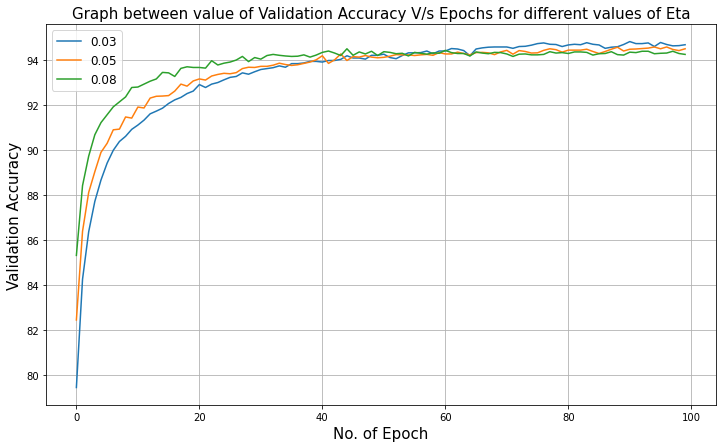



__________________________________________________




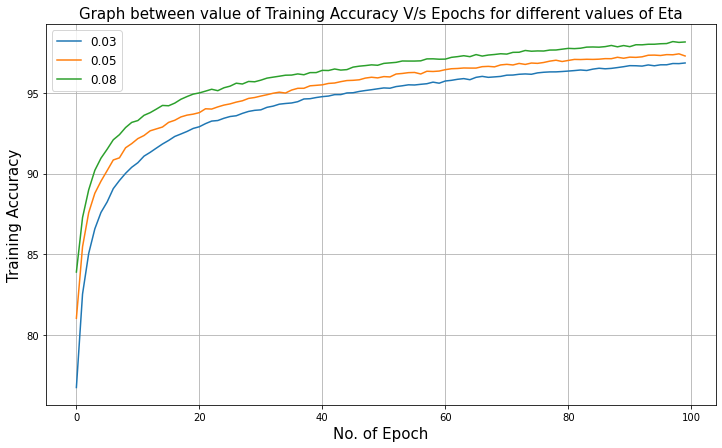

In [22]:
plt.figure(figsize =(12,7))
for i in range(len(eval_acc_list_1)):
    plt.plot(eval_acc_list_1[i])
plt.ylabel("Validation Accuracy",fontsize = 15)
plt.xlabel("No. of Epoch",fontsize = 15)
plt.legend([0.03,0.05,0.08],loc='best',fontsize=12)
plt.title("Graph between value of Validation Accuracy V/s Epochs for different values of Eta",fontsize = 15)
plt.grid()
plt.show()
print("\n\n__________________________________________________\n\n")

plt.figure(figsize =(12,7))
for i in range(len(train_acc_list_1)):
    plt.plot(train_acc_list_1[i])
plt.ylabel("Training Accuracy",fontsize = 15)
plt.xlabel("No. of Epoch",fontsize = 15)
plt.legend([00.03,0.05,0.08],loc='best',fontsize=12)
plt.title("Graph between value of Training Accuracy V/s Epochs for different values of Eta",fontsize = 15)
plt.grid()
plt.show()

**Graph between values of Validation Loss and Training V/s Epochs for different values of Eta**

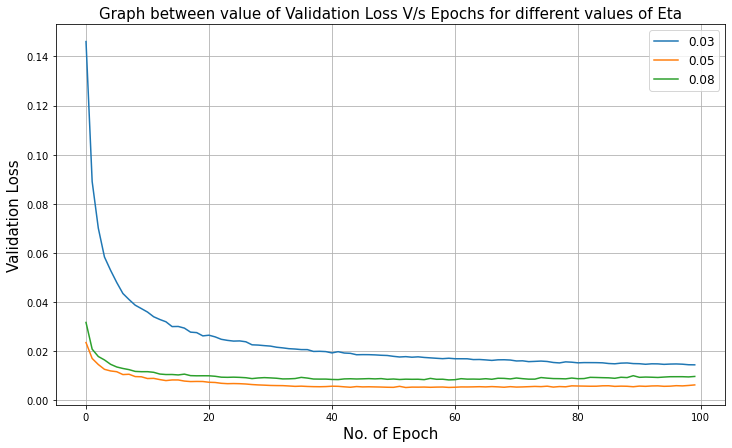



__________________________________________________




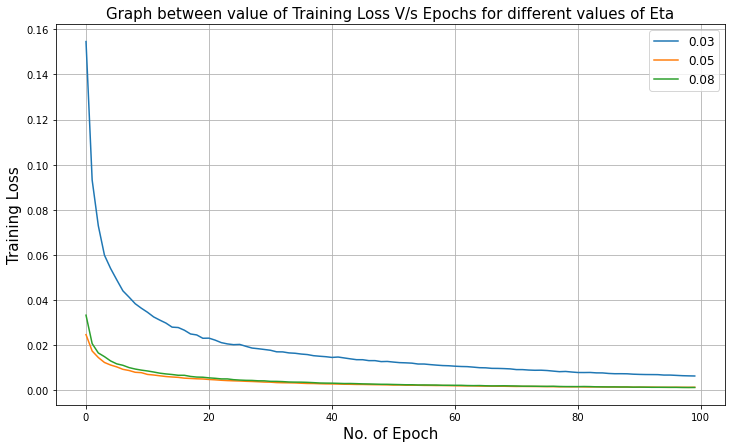

In [23]:
plt.figure(figsize =(12,7))
for i in range(len(eval_cost_list_1)):
    plt.plot(eval_cost_list_1[i])
plt.ylabel("Validation Loss",fontsize = 15)
plt.xlabel("No. of Epoch",fontsize = 15)
plt.legend([0.03,0.05,0.08],loc='best',fontsize=12)
plt.title("Graph between value of Validation Loss V/s Epochs for different values of Eta",fontsize = 15)
plt.grid()
plt.show()
print("\n\n__________________________________________________\n\n")

plt.figure(figsize =(12,7))
for i in range(len(train_cost_list_1)):
    plt.plot(train_cost_list_1[i],label = "Training Loss")
plt.ylabel("Training Loss",fontsize = 15)
plt.xlabel("No. of Epoch",fontsize = 15)
plt.legend([0.03,0.05,0.08],loc='best',fontsize=12)
plt.title("Graph between value of Training Loss V/s Epochs for different values of Eta",fontsize = 15)
plt.grid()
plt.show()

In [24]:
for i in range(len(eta)):
  print("The final validation accuracy for ",eta[i],"Eta value is =",eval_acc_list_1[-len(eta)+i][-1],"\n")

The final validation accuracy for  0.03 Eta value is = 94.67 

The final validation accuracy for  0.05 Eta value is = 94.49 

The final validation accuracy for  0.08 Eta value is = 94.24 



**Observation- Setting the Eta value as 0.05**

# **Computing for different values of mini batch size-**

In [25]:
net = Network([784, 28, 10], cost = CrossEntropyCost)
epochs = 100
mini_batch_size = [1,5,10,50,100,200,50000]
eta = 0.05
lmbda = 0
evaluation_data = validation_data
dash = "_____________________________________________________________"
eval_cost_list_2 = []
eval_acc_list_2 = []
train_cost_list_2 = []
train_acc_list_2 = []
for i in range(len(mini_batch_size)):
  net.large_weight_initializer()
  print("Calculations for the mini batch size value =",mini_batch_size[i],"\n")
  eval_cost,eval_acc,train_cost,train_acc = net.SGD(training_data, epochs, mini_batch_size[i], eta, lmbda,evaluation_data,monitor_evaluation_cost, monitor_evaluation_accuracy,monitor_training_cost, monitor_training_accuracy)
  eval_cost_list_2.append(eval_cost)
  eval_acc_list_2.append(eval_acc)
  train_cost_list_2.append(train_cost)
  train_acc_list_2.append(train_acc)
  print(dash)

Calculations for the mini batch size value = 1 

Epoch 0 training complete

Accuracy on evaluation data: 9145 / 10000
_________________________________________________________________

Epoch 1 training complete

Accuracy on evaluation data: 9291 / 10000
_________________________________________________________________

Epoch 2 training complete

Accuracy on evaluation data: 9333 / 10000
_________________________________________________________________

Epoch 3 training complete

Accuracy on evaluation data: 9411 / 10000
_________________________________________________________________

Epoch 4 training complete

Accuracy on evaluation data: 9393 / 10000
_________________________________________________________________

Epoch 5 training complete

Accuracy on evaluation data: 9485 / 10000
_________________________________________________________________

Epoch 6 training complete

Accuracy on evaluation data: 9495 / 10000
_________________________________________________________________


**Graph between value of Validation Accuracy and Training Accuracy V/s Epochs for different values of Mini batch size**

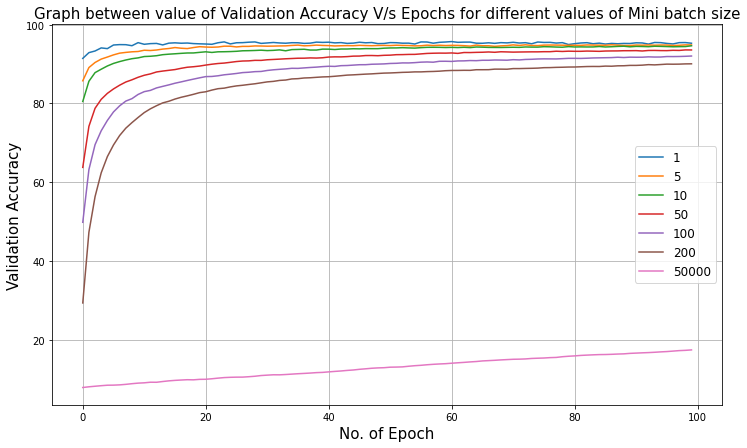



__________________________________________________




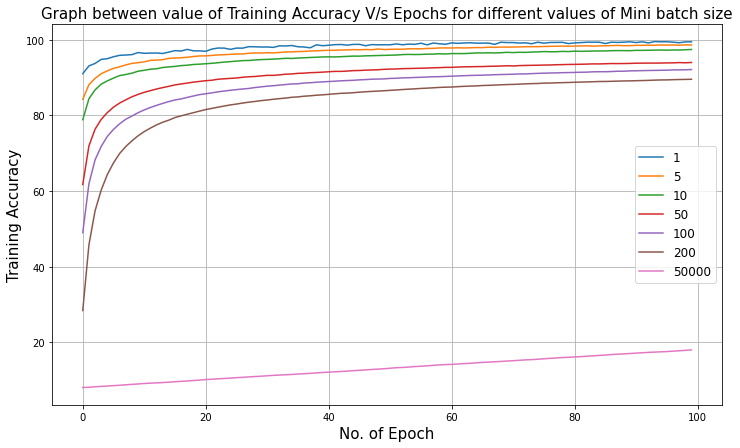

In [26]:
plt.figure(figsize =(12,7))
for i in range(len(eval_acc_list_2)):
    plt.plot(eval_acc_list_2[i])
plt.ylabel("Validation Accuracy",fontsize = 15)
plt.xlabel("No. of Epoch",fontsize = 15)
plt.legend([1,5,10,50,100,200,50000],loc='best',fontsize=12)
plt.title("Graph between value of Validation Accuracy V/s Epochs for different values of Mini batch size",fontsize = 15)
plt.grid()
plt.show()
print("\n\n__________________________________________________\n\n")

plt.figure(figsize =(12,7))
for i in range(len(train_acc_list_2)):
    plt.plot(train_acc_list_2[i])
plt.ylabel("Training Accuracy",fontsize = 15)
plt.xlabel("No. of Epoch",fontsize = 15)
plt.legend([1,5,10,50,100,200,50000],loc='best',fontsize=12)
plt.title("Graph between value of Training Accuracy V/s Epochs for different values of Mini batch size",fontsize = 15)
plt.grid()
plt.show()

**Graph between value of Validation Loss and Training Loss V/s Epochs for different values of Mini batch size**

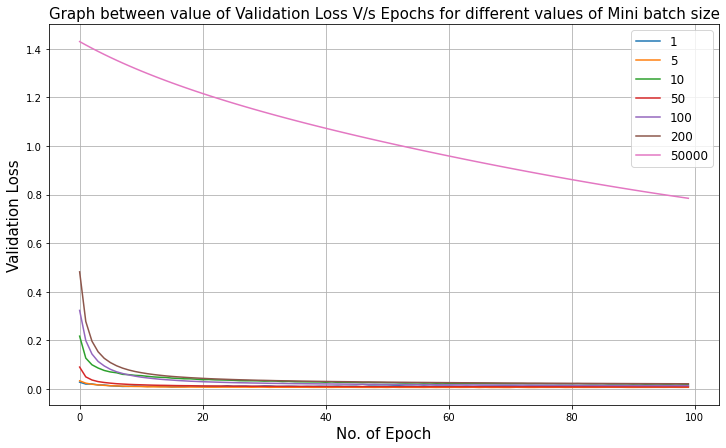



__________________________________________________




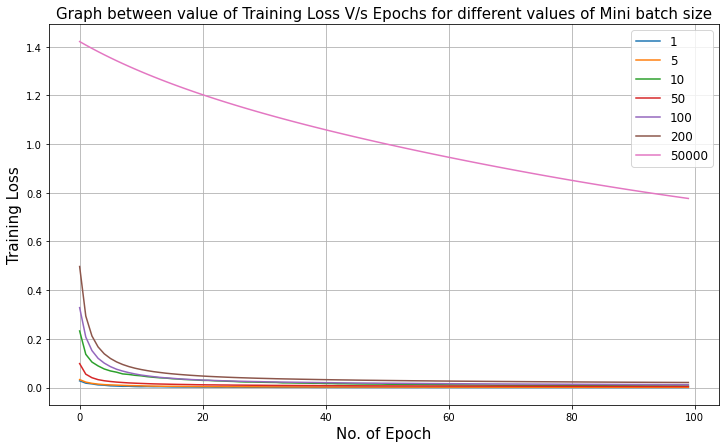

In [27]:
plt.figure(figsize =(12,7))
for i in range(len(eval_cost_list_2)):
    plt.plot(eval_cost_list_2[i])
plt.ylabel("Validation Loss",fontsize = 15)
plt.xlabel("No. of Epoch",fontsize = 15)
plt.legend([1,5,10,50,100,200,50000],loc='best',fontsize=12)
plt.title("Graph between value of Validation Loss V/s Epochs for different values of Mini batch size",fontsize = 15)
plt.grid()
plt.show()
print("\n\n__________________________________________________\n\n")

plt.figure(figsize =(12,7))
for i in range(len(train_cost_list_2)):
    plt.plot(train_cost_list_2[i])
plt.ylabel("Training Loss",fontsize = 15)
plt.xlabel("No. of Epoch",fontsize = 15)
plt.legend([1,5,10,50,100,200,50000],loc='best',fontsize=12)
plt.title("Graph between value of Training Loss V/s Epochs for different values of Mini batch size",fontsize = 15)
plt.grid()
plt.show()

In [28]:
for i in range(len(mini_batch_size)):
  print("The final validation accuracy for ",mini_batch_size[i],"Mini batch size value is =",eval_acc_list_2[-len(mini_batch_size)+i][-1],"\n")

The final validation accuracy for  1 Mini batch size value is = 95.3 

The final validation accuracy for  5 Mini batch size value is = 94.86 

The final validation accuracy for  10 Mini batch size value is = 94.65 

The final validation accuracy for  50 Mini batch size value is = 93.58999999999999 

The final validation accuracy for  100 Mini batch size value is = 92.05 

The final validation accuracy for  200 Mini batch size value is = 90.07 

The final validation accuracy for  50000 Mini batch size value is = 17.39 



# **Computing for different Epoch values-**

In [29]:
net = Network([784, 28, 10], cost = CrossEntropyCost)
epochs = [100,200,300,400]
mini_batch_size = 5
eta = 0.05
lmbda = 0
evaluation_data = validation_data
net.large_weight_initializer()
dash = "_____________________________________________________________"
eval_cost_list_3 = []
eval_acc_list_3 = []
train_cost_list_3 = []
train_acc_list_3 = []
for i in range(len(epochs)):
  net.large_weight_initializer()
  print("Calculations for the epochs size value =",epochs[i],"\n")
  eval_cost,eval_acc,train_cost,train_acc = net.SGD(training_data, epochs[i], mini_batch_size, eta, lmbda,evaluation_data,monitor_evaluation_cost, monitor_evaluation_accuracy,monitor_training_cost, monitor_training_accuracy)
  eval_cost_list_3.append(eval_cost)
  eval_acc_list_3.append(eval_acc)
  train_cost_list_3.append(train_cost)
  train_acc_list_3.append(train_acc)
  print(dash)

Calculations for the epochs size value = 100 

Epoch 0 training complete

Accuracy on evaluation data: 8674 / 10000
_________________________________________________________________

Epoch 1 training complete

Accuracy on evaluation data: 8976 / 10000
_________________________________________________________________

Epoch 2 training complete

Accuracy on evaluation data: 9077 / 10000
_________________________________________________________________

Epoch 3 training complete

Accuracy on evaluation data: 9160 / 10000
_________________________________________________________________

Epoch 4 training complete

Accuracy on evaluation data: 9183 / 10000
_________________________________________________________________

Epoch 5 training complete

Accuracy on evaluation data: 9231 / 10000
_________________________________________________________________

Epoch 6 training complete

Accuracy on evaluation data: 9262 / 10000
_________________________________________________________________

E

**Graph between value of Validation Accuracy and Training Accuracy V/s Epochs for different values of Epochs Size**

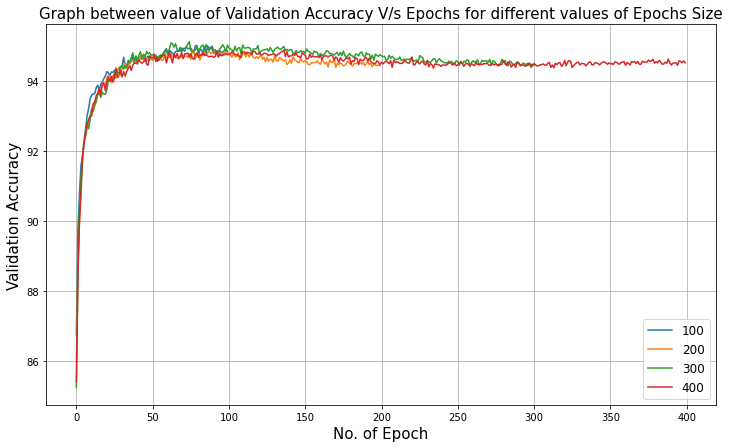



__________________________________________________




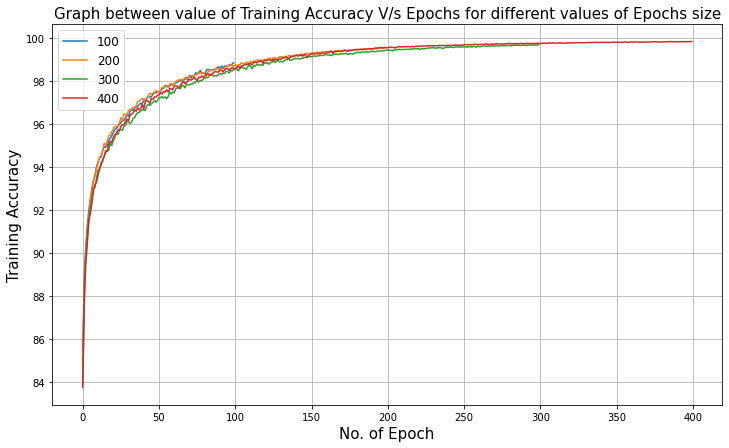

In [30]:
plt.figure(figsize =(12,7))
for i in range(len(eval_acc_list_3)):
    plt.plot(eval_acc_list_3[i])
plt.ylabel("Validation Accuracy",fontsize = 15)
plt.xlabel("No. of Epoch",fontsize = 15)
plt.legend([100,200,300,400],loc='best',fontsize=12)
plt.title("Graph between value of Validation Accuracy V/s Epochs for different values of Epochs Size",fontsize = 15)
plt.grid()
plt.show()
print("\n\n__________________________________________________\n\n")

plt.figure(figsize =(12,7))
for i in range(len(train_acc_list_3)):
    plt.plot(train_acc_list_3[i])
plt.ylabel("Training Accuracy",fontsize = 15)
plt.xlabel("No. of Epoch",fontsize = 15)
plt.legend([100,200,300,400],loc='best',fontsize=12)
plt.title("Graph between value of Training Accuracy V/s Epochs for different values of Epochs size",fontsize = 15)
plt.grid()
plt.show()

**Graph between value of Validation Loss and Training Loss V/s Epochs for different values of Epochs Size**

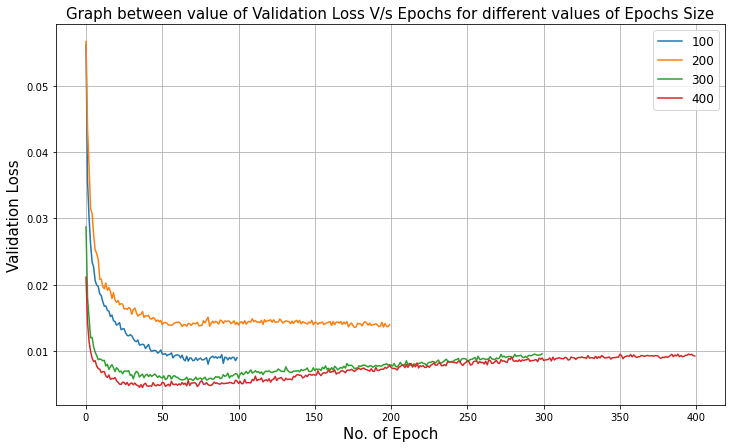



__________________________________________________




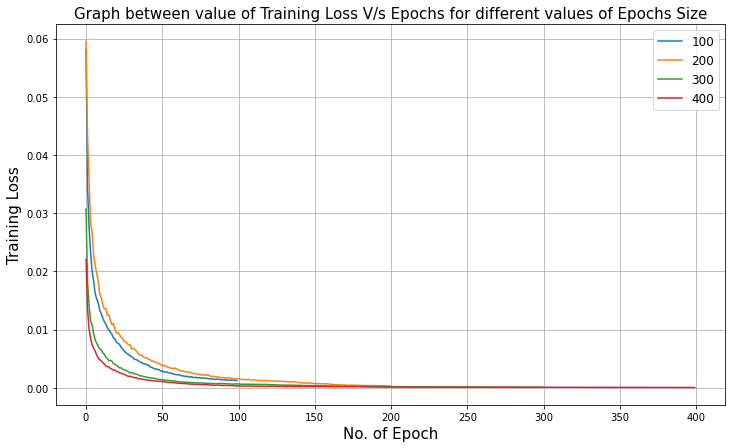

In [31]:
plt.figure(figsize =(12,7))
for i in range(len(eval_cost_list_3)):
    plt.plot(eval_cost_list_3[i])
plt.ylabel("Validation Loss",fontsize = 15)
plt.xlabel("No. of Epoch",fontsize = 15)
plt.legend([100,200,300,400],loc='best',fontsize=12)
plt.title("Graph between value of Validation Loss V/s Epochs for different values of Epochs Size",fontsize = 15)
plt.grid()
plt.show()
print("\n\n__________________________________________________\n\n")

plt.figure(figsize =(12,7))
for i in range(len(train_cost_list_3)):
    plt.plot(train_cost_list_3[i])
plt.ylabel("Training Loss",fontsize = 15)
plt.xlabel("No. of Epoch",fontsize = 15)
plt.legend([100,200,300,400],loc='best',fontsize=12)
plt.title("Graph between value of Training Loss V/s Epochs for different values of Epochs Size",fontsize = 15)
plt.grid()
plt.show()

In [32]:
for i in range(len(epochs)):
  print("The final validation accuracy for ",epochs[i],"Epochs size value is =",eval_acc_list_3[-len(epochs)+i][-1],"\n")

The final validation accuracy for  100 Epochs size value is = 94.87 

The final validation accuracy for  200 Epochs size value is = 94.45 

The final validation accuracy for  300 Epochs size value is = 94.49 

The final validation accuracy for  400 Epochs size value is = 94.53 



**Observation-** Best performance is for epoch size of 100.

# **Now, We increase the hidden layers-**

In [33]:
net = Network([784, 28,15, 10], cost=CrossEntropyCost)
epochs = 100
mini_batch_size = 5
eta = 0.05
lmbda = 0
evaluation_data = validation_data
monitor_evaluation_cost = True
monitor_evaluation_accuracy = True
monitor_training_cost = True
monitor_training_accuracy = True
net.large_weight_initializer()
eval_cost,eval_acc,train_cost,train_acc = net.SGD(training_data, epochs, mini_batch_size, eta, lmbda,evaluation_data,monitor_evaluation_cost, monitor_evaluation_accuracy,monitor_training_cost, monitor_training_accuracy)

Epoch 0 training complete

Accuracy on evaluation data: 8469 / 10000
_________________________________________________________________

Epoch 1 training complete

Accuracy on evaluation data: 8836 / 10000
_________________________________________________________________

Epoch 2 training complete

Accuracy on evaluation data: 9036 / 10000
_________________________________________________________________

Epoch 3 training complete

Accuracy on evaluation data: 9121 / 10000
_________________________________________________________________

Epoch 4 training complete

Accuracy on evaluation data: 9166 / 10000
_________________________________________________________________

Epoch 5 training complete

Accuracy on evaluation data: 9222 / 10000
_________________________________________________________________

Epoch 6 training complete

Accuracy on evaluation data: 9241 / 10000
_________________________________________________________________

Epoch 7 training complete

Accuracy on evaluatio

In [34]:
df = TabularFormat(epochs,eval_cost,eval_acc,train_cost,train_acc)
df

,Epoch Value,Training Loss,Training Accuracy,Evaluation loss,Evaluation Accuracy
0,0,0.097150,83.216,0.092283,84.69
1,1,0.060680,87.506,0.059472,88.36
2,2,0.046929,90.004,0.047564,90.36
3,3,0.039112,90.960,0.041784,91.21
4,4,0.033782,91.720,0.038325,91.66
...,...,...,...,...,...
95,95,0.001622,98.898,0.018162,94.55
96,96,0.001495,99.004,0.018464,94.68
97,97,0.001464,98.998,0.017750,94.64
98,98,0.001480,99.104,0.017801,94.62


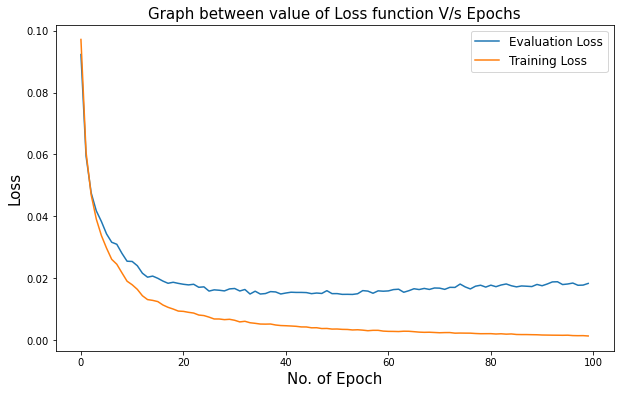



__________________________________________________




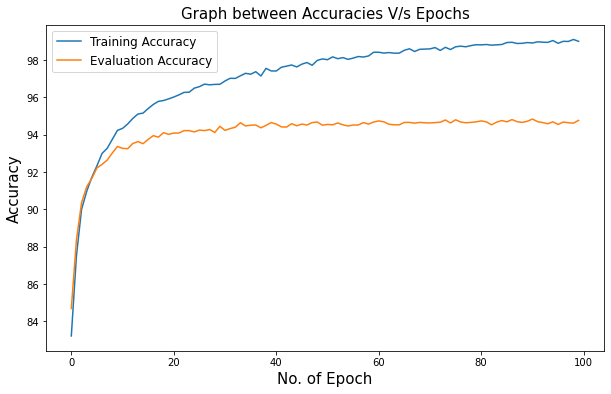

In [35]:
GraphicalFormat(epochs,eval_cost,eval_acc,train_cost,train_acc)

# # Now, we introduce L2 regularisation-

**We fix the number of epochs to 100, Eta to be 0.05 and mini batch size to 5, and see the results for different values of the parameter lambda-**

**Here, we are taking the weight decay as (lambda/2*n)-**

In [36]:
net = Network([784, 28, 10], cost=CrossEntropyCost)
epochs = 100
mini_batch_size = 5
eta = 0.05
lmbda = [0,1,2,5,8,10]
evaluation_data = validation_data
dash = "_____________________________________________________________"
eval_cost_list_4 = []
eval_acc_list_4 = []
train_cost_list_4 = []
train_acc_list_4 = []
for i in range(len(lmbda)):
  net.large_weight_initializer()
  print("Calculations for the lambda value =",lmbda[i],"\n")
  eval_cost,eval_acc,train_cost,train_acc = net.SGD(training_data, epochs, mini_batch_size, eta, lmbda[i],evaluation_data,monitor_evaluation_cost, monitor_evaluation_accuracy,monitor_training_cost, monitor_training_accuracy)
  eval_cost_list_4.append(eval_cost)
  eval_acc_list_4.append(eval_acc)
  train_cost_list_4.append(train_cost)
  train_acc_list_4.append(train_acc)
  print(dash)

Calculations for the lambda value = 0 

Epoch 0 training complete

Accuracy on evaluation data: 8598 / 10000
_________________________________________________________________

Epoch 1 training complete

Accuracy on evaluation data: 8909 / 10000
_________________________________________________________________

Epoch 2 training complete

Accuracy on evaluation data: 9014 / 10000
_________________________________________________________________

Epoch 3 training complete

Accuracy on evaluation data: 9098 / 10000
_________________________________________________________________

Epoch 4 training complete

Accuracy on evaluation data: 9184 / 10000
_________________________________________________________________

Epoch 5 training complete

Accuracy on evaluation data: 9210 / 10000
_________________________________________________________________

Epoch 6 training complete

Accuracy on evaluation data: 9250 / 10000
_________________________________________________________________

Epoch 7 

**Graph between value of Validation Accuracy and Training Accuracy V/s Epochs for different values of Lambda**

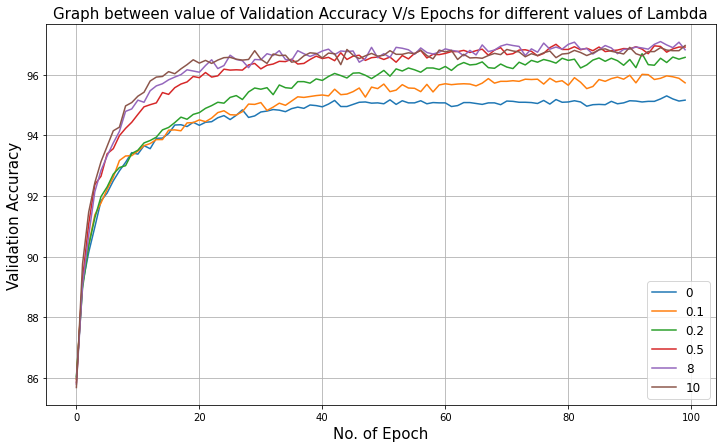



__________________________________________________




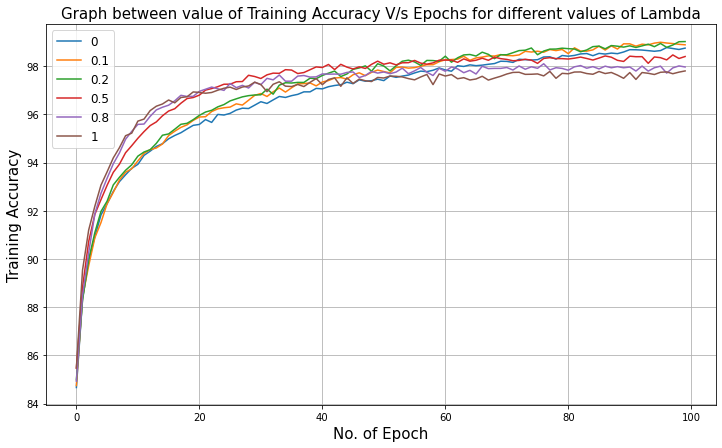

In [37]:
plt.figure(figsize =(12,7))
for i in range(len(lmbda)):
    plt.plot(eval_acc_list_4[i])
plt.ylabel("Validation Accuracy",fontsize = 15)
plt.xlabel("No. of Epoch",fontsize = 15)
plt.legend([0,0.1,0.2,0.5,8,10],loc='best',fontsize=12)
plt.title("Graph between value of Validation Accuracy V/s Epochs for different values of Lambda",fontsize = 15)
plt.grid()
plt.show()
print("\n\n__________________________________________________\n\n")

plt.figure(figsize =(12,7))
for i in range(len(lmbda)):
    plt.plot(train_acc_list_4[i])
plt.ylabel("Training Accuracy",fontsize = 15)
plt.xlabel("No. of Epoch",fontsize = 15)
plt.legend([0,0.1,0.2,0.5,0.8,1],loc='best',fontsize=12)
plt.title("Graph between value of Training Accuracy V/s Epochs for different values of Lambda",fontsize = 15)
plt.grid()
plt.show()

**Graph between value of Validation Loss and Training Loss V/s Epochs for different values of Lambda**

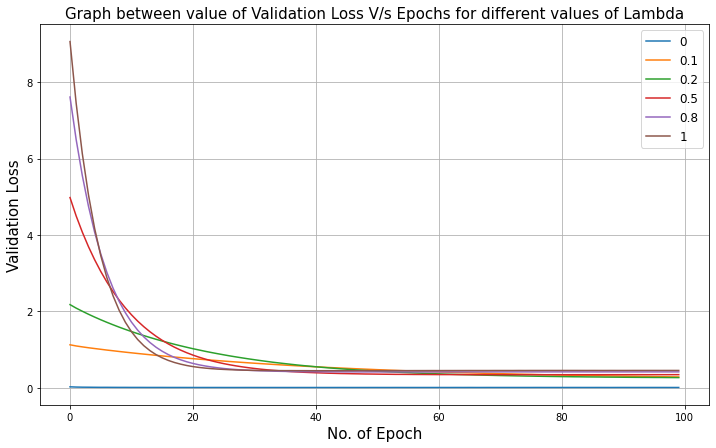



__________________________________________________




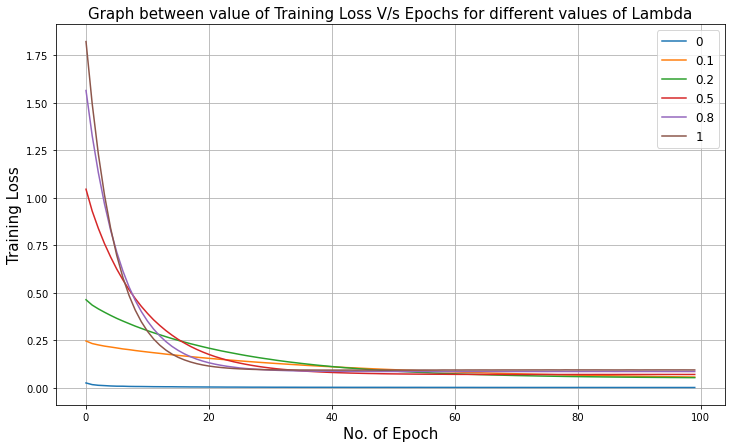

In [38]:
plt.figure(figsize =(12,7))
for i in range(len(lmbda)):
    plt.plot(eval_cost_list_4[i])
plt.ylabel("Validation Loss",fontsize = 15)
plt.xlabel("No. of Epoch",fontsize = 15)
plt.legend([0,0.1,0.2,0.5,0.8,1],loc='best',fontsize=12)
plt.title("Graph between value of Validation Loss V/s Epochs for different values of Lambda",fontsize = 15)
plt.grid()
plt.show()
print("\n\n__________________________________________________\n\n")

plt.figure(figsize =(12,7))
for i in range(len(lmbda)):
    plt.plot(train_cost_list_4[i])
plt.ylabel("Training Loss",fontsize = 15)
plt.xlabel("No. of Epoch",fontsize = 15)
plt.legend([0,0.1,0.2,0.5,0.8,1],loc='best',fontsize=12)
plt.title("Graph between value of Training Loss V/s Epochs for different values of Lambda",fontsize = 15)
plt.grid()
plt.show()

**Printing the results for final accuracies at each values of lambda-**

In [39]:
for i in range(len(lmbda)):
  print("The final validation accuracy for ",lmbda[i],"Lambda value is =",eval_acc_list_4[-len(lmbda)+i][-1],"\n") 

The final validation accuracy for  0 Lambda value is = 95.16 

The final validation accuracy for  1 Lambda value is = 95.73 

The final validation accuracy for  2 Lambda value is = 96.57 

The final validation accuracy for  5 Lambda value is = 96.91 

The final validation accuracy for  8 Lambda value is = 96.82 

The final validation accuracy for  10 Lambda value is = 96.96000000000001 



**The best result is for lambda value of 0.5**

# Now, training the neural network with the values of hyperparameters that we got and evaluating the performance on testing data- 

**Epochs - 100**

**Mini batch size = 5**

**Eta = 0.05**

**Lambda = 0.5**

In [40]:
net = Network([784, 28,10], cost=CrossEntropyCost)
epochs = 100
mini_batch_size = 5
eta = 0.05
lmbda = 0.5
evaluation_data = test_data
monitor_evaluation_cost = True
monitor_evaluation_accuracy = True
monitor_training_cost = True
monitor_training_accuracy = True
net.large_weight_initializer()
eval_cost,eval_acc,train_cost,train_acc = net.SGD(training_data, epochs, mini_batch_size, eta, lmbda,evaluation_data,monitor_evaluation_cost, monitor_evaluation_accuracy,monitor_training_cost, monitor_training_accuracy)

Epoch 0 training complete

Accuracy on evaluation data: 8580 / 10000
_________________________________________________________________

Epoch 1 training complete

Accuracy on evaluation data: 8852 / 10000
_________________________________________________________________

Epoch 2 training complete

Accuracy on evaluation data: 8988 / 10000
_________________________________________________________________

Epoch 3 training complete

Accuracy on evaluation data: 9049 / 10000
_________________________________________________________________

Epoch 4 training complete

Accuracy on evaluation data: 9109 / 10000
_________________________________________________________________

Epoch 5 training complete

Accuracy on evaluation data: 9167 / 10000
_________________________________________________________________

Epoch 6 training complete

Accuracy on evaluation data: 9174 / 10000
_________________________________________________________________

Epoch 7 training complete

Accuracy on evaluatio

In [41]:
df = TabularFormat(epochs,eval_cost,eval_acc,train_cost,train_acc)
df

,Epoch Value,Training Loss,Training Accuracy,Evaluation loss,Evaluation Accuracy
0,0,0.178713,85.294,0.619441,85.80
1,1,0.155393,88.446,0.591976,88.52
2,2,0.144971,90.168,0.576889,89.88
3,3,0.138951,90.898,0.569312,90.49
4,4,0.133383,91.846,0.558745,91.09
...,...,...,...,...,...
95,95,0.056035,98.730,0.282511,95.29
96,96,0.055661,98.904,0.280997,95.40
97,97,0.055385,98.722,0.279559,95.23
98,98,0.055053,98.856,0.278142,95.35


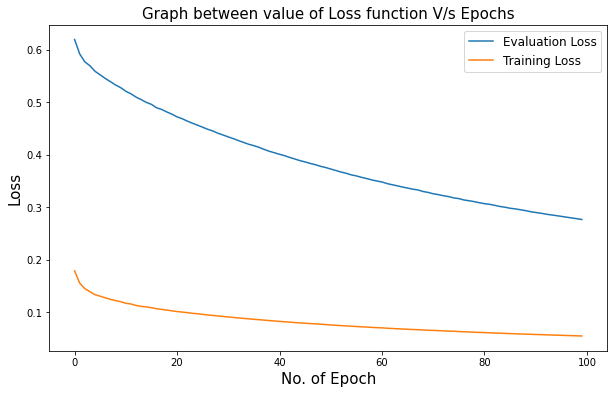



__________________________________________________




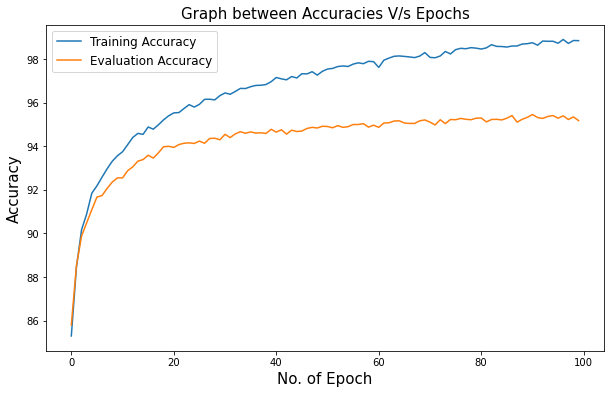

In [42]:
GraphicalFormat(epochs,eval_cost,eval_acc,train_cost,train_acc)

In [43]:
eval_cost_without_wt = eval_cost
eval_acc_without_wt = eval_acc
train_cost_without_wt = train_cost 
train_acc_without_wt = train_acc

#  Now, we introduce weight initialisation-

In [44]:
net = Network([784, 28,10], cost=CrossEntropyCost)
epochs = 100
mini_batch_size = 5
eta = 0.05
lmbda = 0.5
evaluation_data = test_data
monitor_evaluation_cost = True
monitor_evaluation_accuracy = True
monitor_training_cost = True
monitor_training_accuracy = True
net.default_weight_initializer()
eval_cost,eval_acc,train_cost,train_acc = net.SGD(training_data, epochs, mini_batch_size, eta, lmbda,evaluation_data,monitor_evaluation_cost, monitor_evaluation_accuracy,monitor_training_cost, monitor_training_accuracy)

Epoch 0 training complete

Accuracy on evaluation data: 9253 / 10000
_________________________________________________________________

Epoch 1 training complete

Accuracy on evaluation data: 9387 / 10000
_________________________________________________________________

Epoch 2 training complete

Accuracy on evaluation data: 9456 / 10000
_________________________________________________________________

Epoch 3 training complete

Accuracy on evaluation data: 9514 / 10000
_________________________________________________________________

Epoch 4 training complete

Accuracy on evaluation data: 9543 / 10000
_________________________________________________________________

Epoch 5 training complete

Accuracy on evaluation data: 9559 / 10000
_________________________________________________________________

Epoch 6 training complete

Accuracy on evaluation data: 9572 / 10000
_________________________________________________________________

Epoch 7 training complete

Accuracy on evaluatio

In [45]:
df = TabularFormat(epochs,eval_cost,eval_acc,train_cost,train_acc)
df

,Epoch Value,Training Loss,Training Accuracy,Evaluation loss,Evaluation Accuracy
0,0,0.012113,92.330,0.020139,92.53
1,1,0.010018,93.954,0.021378,93.87
2,2,0.008701,94.846,0.022641,94.56
3,3,0.008238,95.514,0.024526,95.14
4,4,0.007909,96.038,0.025957,95.43
...,...,...,...,...,...
95,95,0.020704,99.860,0.105312,96.48
96,96,0.020761,99.794,0.105663,96.42
97,97,0.020812,99.806,0.105647,96.45
98,98,0.020868,99.660,0.106167,96.01


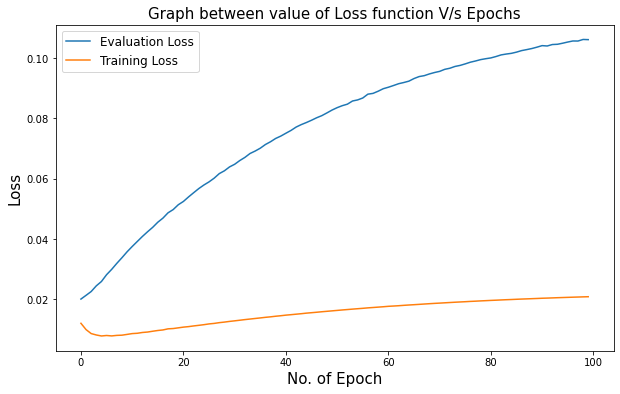



__________________________________________________




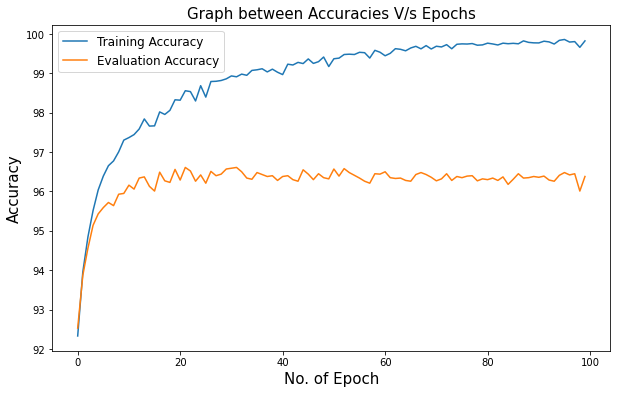

In [46]:
GraphicalFormat(epochs,eval_cost,eval_acc,train_cost,train_acc)

In [47]:
eval_cost_with_wt = eval_cost
eval_acc_with_wt = eval_acc
train_cost_with_wt = train_cost 
train_acc_with_wt = train_acc

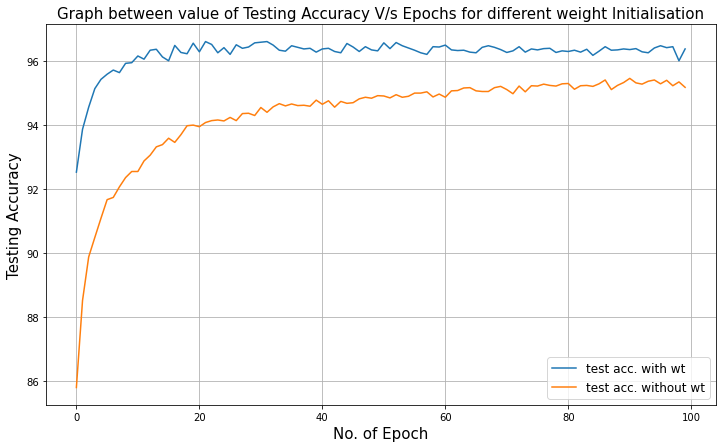



__________________________________________________




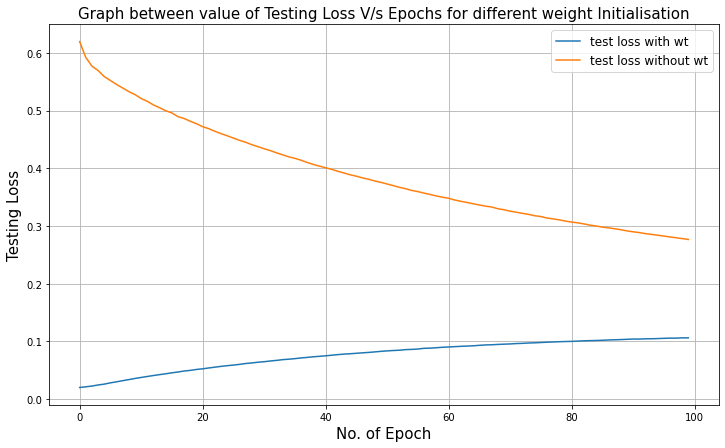



__________________________________________________




In [48]:
plt.figure(figsize =(12,7))
plt.plot(eval_acc_with_wt)
plt.plot(eval_acc_without_wt)
plt.ylabel("Testing Accuracy",fontsize = 15)
plt.xlabel("No. of Epoch",fontsize = 15)
plt.legend(["test acc. with wt","test acc. without wt"],loc='best',fontsize=12)
plt.title("Graph between value of Testing Accuracy V/s Epochs for different weight Initialisation",fontsize = 15)
plt.grid()
plt.show()
print("\n\n__________________________________________________\n\n")

plt.figure(figsize =(12,7))
plt.plot(eval_cost_with_wt)
plt.plot(eval_cost_without_wt)
plt.ylabel("Testing Loss",fontsize = 15)
plt.xlabel("No. of Epoch",fontsize = 15)
plt.legend(["test loss with wt","test loss without wt"],loc='best',fontsize=12)
plt.title("Graph between value of Testing Loss V/s Epochs for different weight Initialisation",fontsize = 15)
plt.grid()
plt.show()
print("\n\n__________________________________________________\n\n")

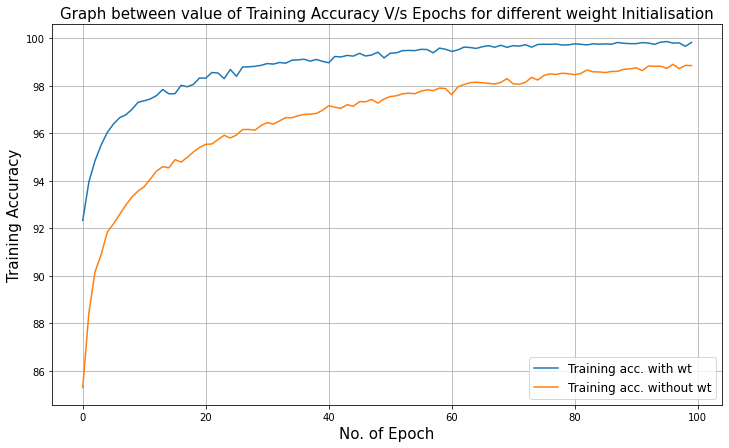



__________________________________________________




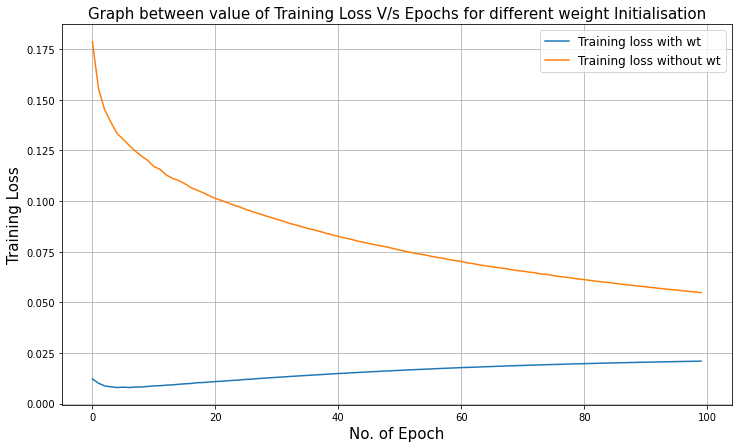



__________________________________________________




In [49]:
plt.figure(figsize =(12,7))
plt.plot(train_acc_with_wt)
plt.plot(train_acc_without_wt)
plt.ylabel("Training Accuracy",fontsize = 15)
plt.xlabel("No. of Epoch",fontsize = 15)
plt.legend(["Training acc. with wt","Training acc. without wt"],loc='best',fontsize=12)
plt.title("Graph between value of Training Accuracy V/s Epochs for different weight Initialisation",fontsize = 15)
plt.grid()
plt.show()
print("\n\n__________________________________________________\n\n")

plt.figure(figsize =(12,7))
plt.plot(train_cost_with_wt)
plt.plot(train_cost_without_wt)
plt.ylabel("Training Loss",fontsize = 15)
plt.xlabel("No. of Epoch",fontsize = 15)
plt.legend(["Training loss with wt","Training loss without wt"],loc='best',fontsize=12)
plt.title("Graph between value of Training Loss V/s Epochs for different weight Initialisation",fontsize = 15)
plt.grid()
plt.show()
print("\n\n__________________________________________________\n\n")

In [50]:
df= pd.DataFrame(list(zip(eval_cost_with_wt,eval_cost_without_wt,eval_acc_with_wt,eval_acc_without_wt)),columns = ['Validation loss with weight Initialisation','Validation loss without weight Initialisation','Validation Accuracy with weight Initialisation','Validation Accuracy without weight Initialisation'])
df

,Validation loss with weight Initialisation,Validation loss without weight Initialisation,Validation Accuracy with weight Initialisation,Validation Accuracy without weight Initialisation
0,0.020139,0.619441,92.53,85.80
1,0.021378,0.591976,93.87,88.52
2,0.022641,0.576889,94.56,89.88
3,0.024526,0.569312,95.14,90.49
4,0.025957,0.558745,95.43,91.09
...,...,...,...,...
95,0.105312,0.282511,96.48,95.29
96,0.105663,0.280997,96.42,95.40
97,0.105647,0.279559,96.45,95.23
98,0.106167,0.278142,96.01,95.35
